# Addestramento di una rete neurale Faster R-CNN per la detection di luoghi ad alto valore culturale

Librerie da importare:


In [93]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import os
import re
import glob
import random
import xml.etree.ElementTree as ET

# Dataset utilizzato

Sono stati individuati **24 punti di interesse** suddivisi in altrettante directories. 



Ogni punto di interesse contiene, a sua volta, altre tre directory:
- *imgs*: contiene le immagini di dimensione 900 x 1300;
- *annotations*: contiene le annotazioni (coordinate delle bounding box) di ogni immagine catturata;
- *bounding_box*: contiene le immagini con le bouding box individuate.


## Connessione a Google Drive

Connessione a google drive per scaricare il dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = "gdrive/MyDrive/DataSet/DatasetMonuments/"   # Replace with your path

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Caricamento del dataset

### Classe del dataset

Per ogni etichetta, verrà creata un'istanza della classe *DatasetCulturalHeritage*

In [108]:
class DatasetCulturalHeritage(Dataset):
  r"""
  Class to load the dataset of a specific label.
  """

  def __init__(self, label, label_ds, dir):
      r"""
      Load the dataset.
      :param label: label of the dataset.
      :param label_ds: label of the dataset not formatted. 
      :param dir: directory of the monumnet/place.
      """

      self.label_name   = label
      self.label_ds     = label_ds
      self.img_list     = glob.glob(dir + self.label_ds + '/imgs/*.JPG') + glob.glob(dir + self.label_ds + '/imgs/*.jpg')
      self.mask_list    = glob.glob(dir + self.label_ds + '/annotations/*.xml')
      print(f"Label [{self.label_name}] loaded!\n")
    

  def __getitem__(self, index):
      r"""
      Get the image and its bouding boxes.
      :param index: index of the specific image
      """
      x, y = self.img_list[index], self.mask_list[index]
      return x, y


  def __len__(self):
      return len(self.img_list)

### Caricamento

La funzione *split_directory* permette di formattare il testo dato in input sulla base delle lettere maiuscole.

In [ ]:
def split_directory(title):
    r"""
    Split text of the directory
    :param title: text to split
    :return: text with the tabulations
    """
    title = title[0].upper() + title[1:]
    folder = re.findall('[A-Z][^A-Z]*', title)
    result = ""
    for i, item in enumerate(folder):
        result += str(item) + (" " if (i + 1) != len(folder) else "")

    return result

Caricamento del dataset.

In [109]:
dataset = []
num_imgs = 0
num_annotation = 0

print("Caricamento dataset in corso ...\n\n")

dirs = os.listdir(path)
for index, dir in enumerate(dirs):

  name_class = split_directory(dir)

  class_label = DatasetCulturalHeritage(name_class, dir, path)
  num_imgs += len(class_label.img_list)
  num_annotation += len(class_label.mask_list)
  dataset.append(class_label)

Caricamento dataset in corso ...


Label [Villino Ruggeri] loaded!

Label [Statua Gioachino Rossini] loaded!

Label [Scultura Della Memoria] loaded!

Label [Rocca Costanza] loaded!

Label [Portale San Domenico] loaded!

Label [Teatro Rossini] loaded!

Label [Statua Giulio Perticari] loaded!

Label [Statua Giuseppe Garibaldi] loaded!

Label [Teatro Sperimentale] loaded!

Label [Villa Caprile] loaded!

Label [Palla Di Pomodoro] loaded!

Label [Palazzo Ducale] loaded!

Label [Parrocchia Santa Maria] loaded!

Label [Palazzo Comunale] loaded!

Label [Palazzo Delle Poste] loaded!

Label [Palazzo Olivieri] loaded!

Label [Chiesa San Agostino] loaded!

Label [Fontana Piazza] loaded!

Label [Centro Arti Visive] loaded!

Label [Palazzo Baviera] loaded!

Label [Arco Di Trionfo] loaded!

Label [Casa Rossini] loaded!

Label [Berlina Mosca] loaded!

Label [Cattedrale Santa Maria Assunta] loaded!

Label [Free] loaded!



In [ ]:
print(f"Numero totale di immagini: {num_imgs}\n")
print(f"Numero totale di annotazioni: {num_annotation}")

Numero totale di immagini: 953

Numero totale di annotazioni: 953


## Visualizzazione del dataset

La funzione *stack_images* permette di mostrare una lista orizzontale e/o verticale di immagini.

In [ ]:
def stack_images(scale, img_array):
    r"""
    Stack the images based on the number of them by rows and columns.
    Resize the images.
    :param scale: scale factor.
    :param img_array: array of images.
    :return: array of images to show.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    rowsAvailable = isinstance(img_array[0], list)

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):

                if img_array[x][y].shape[:2] == img_array[0][0].shape[:2]:
                    img_array[x][y] = cv.resize(img_array[x][y], (0, 0), None, scale, scale)
                else:
                    img_array[x][y] = cv.resize(img_array[x][y], (img_array[0][0].shape[1], img_array[0][0].shape[0]),
                                                None, scale, scale)

                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv.cvtColor(img_array[x][y], cv.COLOR_GRAY2BGR)

        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows

        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
        ver = np.vstack(hor)

    else:
        for x in range(0, rows):

            if img_array[x].shape[:2] == img_array[0].shape[:2]:
                img_array[x] = cv.resize(img_array[x], (0, 0), None, scale, scale)
            else:
                img_array[x] = cv.resize(img_array[x], (img_array[0].shape[1], img_array[0].shape[0]), None, scale,
                                         scale)

            if len(img_array[x].shape) == 2:
                img_array[x] = cv.cvtColor(img_array[x], cv.COLOR_GRAY2BGR)

        hor = np.hstack(img_array)
        ver = hor

    return ver


Visualizzazione casuale di alcune immagini del dataset caricato.

La funzione *draw_description* disegna il nome della classe in basso nell'immagine.

In [88]:
def draw_description(img, text):
    r"""
    Draw description image.
    :param text: image description
    :param img: image in which to insert the descrition
    :return: image with description
    """

    bottom = int(0.04 * img.shape[0])
    img = cv.copyMakeBorder(img, 0, bottom, 0, 0, cv.BORDER_CONSTANT, None, (255, 255, 255))

    height, _, _ = img.shape
    cv.putText(img, text, (0, height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    return img

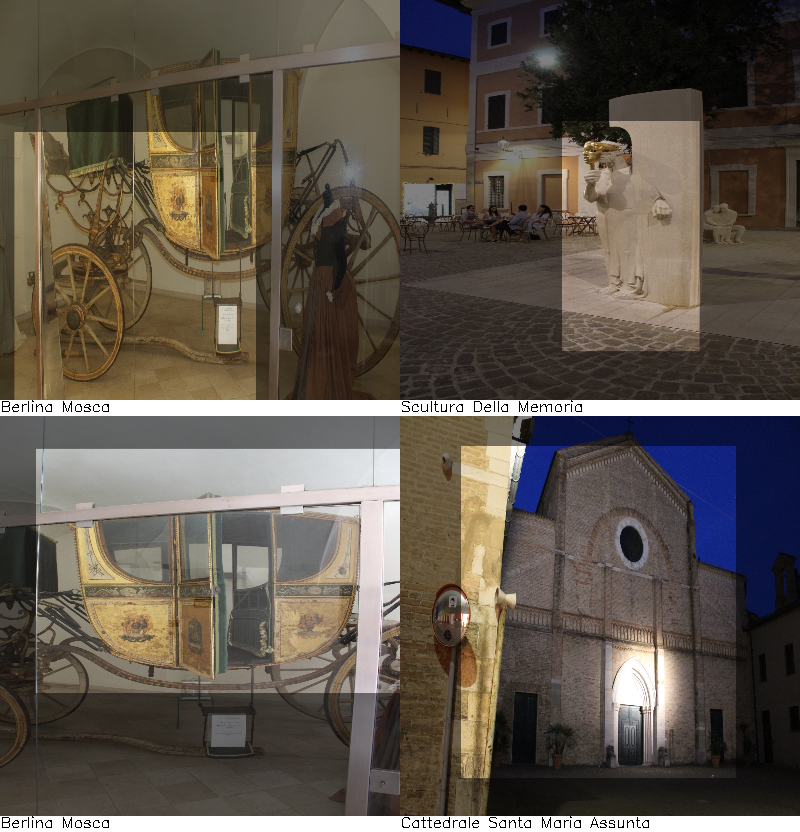

In [101]:
# TODO fix show images
labels_to_show = []
bounding_box_list = []
imgs_list = []
title_images_list = []

labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))

for i in range(0, 4):
    alpha = 0.5
    bounding_box_list.clear()

    index_label = labels_to_show[i]
    class_label = dataset[index_label]

    imgs = class_label.img_list
    annotations = class_label.mask_list
    label = class_label.label_ds

    index_img = random.randint(0, len(imgs) - 1)

    tree = ET.parse(annotations[index_img])
    root = tree.getroot()

    # Get all bounding boxes
    j = 6
    while True:
        try:
            object = root[j]
            box = object[4]
            x_min, y_min, x_max, y_max = int(box[0].text), int(box[1].text), int(box[2].text), int(box[3].text)
            bounding_box_list.append([[x_min - 1, y_min - 1], [x_max - 1, y_max - 1]])
            j += 1
        except:
            break
    
    # Read the image
    img_read = cv.imread(imgs[index_img])

    # Mask
    mask = np.zeros_like(img_read[:, :, 0])

    for j, box in enumerate(bounding_box_list):
        
        cv.rectangle(img_read, box[0], box[1], 125, 5) # TODO fix color
        polygon = np.array([[bounding_box_list[j][0]], [[bounding_box_list[j][1][0], bounding_box_list[j][0][1]]],
                            [bounding_box_list[j][1]], [[bounding_box_list[j][0][0], bounding_box_list[j][1][1]]]])
        cv.fillConvexPoly(mask, polygon, 1)

    # Get polygon
    img = cv.bitwise_and(img_read, img_read, mask=mask)
    img = cv.addWeighted(img_read.copy(), alpha, img, 1 - alpha, 0)
    img = cv.resize(img, (400, 400))
    imgs_list.append(img)

    title_images_list.append(class_label.label_name)


imgs_stack = stack_images(1, ([draw_description(imgs_list[0], title_images_list[0]),
                               draw_description(imgs_list[1], title_images_list[1])],
                              [draw_description(imgs_list[2], title_images_list[2]),
                               draw_description(imgs_list[3], title_images_list[3])]))

cv2_imshow(imgs_stack)

## Trainining, validation e test set

La funzione *train_test_split* suddivide il dataset in training, validation e test set rispettivamente al 70% (training), 20% (validation) e 10% (test).

In [102]:
def train_test_split(dataset):
    r"""
    Slip dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split
    :return : training, validation and test set.
    """
    length_dataset = len(dataset)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset = Subset(dataset, range(0, length_train))
    validation_dataset = Subset(dataset, range(length_train, length_train + length_validate))
    test_dataset = Subset(dataset, range(length_train + length_validate, len(dataset)))

    return training_dataset, validation_dataset, test_dataset

Partizionamento dataset.

In [113]:
trainining_set = []
validation_set = []
test_set = []

for _set in dataset:
    
    training_dataset, validation_dataset, test_dataset = train_test_split(_set)

    trainining_set.append(training_dataset)
    validation_set.append(validation_dataset)
    test_set.append(test_dataset)


training_dataset, validation_dataset, test_dataset = ConcatDataset(trainining_set), ConcatDataset(validation_set), \
                                                     ConcatDataset(test_set)

print(f"** Dataset loaded correctly! Imgs: {len(training_dataset) + len(validation_dataset) + len(test_dataset)} **\n")
print(f"Size training: {len(training_dataset)} - (70%)")
print(f"Size validation: {len(validation_dataset)} - (20%)")
print(f"Size test: {len(test_dataset)} - (10%)")
print(f"Total imgs splitted: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

** Dataset loaded correctly! Imgs: 953 **

Size training: 657 - (70%)
Size validation: 181 - (20%)
Size test: 115 - (10%)
Total imgs splitted: 953


